In [1]:
import numpy as np
import pandas as pd
import string

In [2]:
imp_words = pd.read_json('important_words.json.zip')

In [3]:
df = pd.read_csv('amazon_baby_subset.csv.zip')

In [4]:
df.head(5)

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [5]:
imp_words = [word for word in imp_words[0]]

In [6]:
def remove_punc(txt):
    trans_table = str.maketrans('','',string.punctuation)
    return txt.translate(trans_table)

In [7]:
df = df.fillna({'review':''})

In [8]:
df['review'] = df['review'].apply(lambda x:remove_punc(x))
for word in imp_words:
    df[word] = df['review'].apply(lambda x:x.split(' ').count(word))

In [9]:
train = df.iloc[pd.read_json('module-10-assignment-train-idx.json.zip')[0]].reset_index()
valid = df.iloc[pd.read_json('module-10-assignment-validation-idx.json.zip')[0]].reset_index()

In [10]:
df['contains_perfect'] = df['perfect'].apply(lambda x:1 if (x>0) else 0)

In [11]:
sum(df['contains_perfect'])

2955

In [12]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [13]:
train_matrix , train_label = get_numpy_data(train,imp_words,'sentiment')

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [14]:
valid_matrix , valid_label = get_numpy_data(valid,imp_words,'sentiment')

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [15]:
def predict_proba(feats_matrix,weights):
    score = np.dot(feats_matrix,weights)
    
    proba = 1.0 / (1+np.exp(-1*score))
    return proba

In [16]:
def feat_deriv(errors,feats_matrix):
    return np.dot(errors,feats_matrix)

In [17]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

In [18]:
j = 1
i = 10
weights = np.zeros(len(imp_words)+1)

prediction = predict_proba(train_matrix[i:i+1,:],weights)
indicator = train_label[i:i+1] == 1
errors = indicator - prediction
grad_1 = feat_deriv(errors,train_matrix[i:i+1,j])

In [19]:
grad_1

0.0

In [20]:
len(train_matrix)

47780

In [21]:
j = 1
i = 10
b = 10
weights = np.zeros(len(imp_words)+1)

prediction = predict_proba(train_matrix[i:i+b,:],weights)
indicator = train_label[i:i+b] == 1
errors = indicator - prediction
grad_2 = feat_deriv(errors,train_matrix[i:i+b,j])

In [22]:
grad_2

1.0

In [45]:
def Logistic_Regression_SG(feat_mat,sent,init_weights,step_size,batch_size,max_iter):
    weights = np.array(init_weights)
    
    log_likelihood_all = list()
    #shuffling.
    np.random.seed(seed=1)
    perm = np.random.permutation(len(feat_mat))
    feat_mat = feat_mat[perm,:]
    sent = sent[perm]
    
    i=0
    for itr in range(max_iter):
        indicator = sent[i:i+batch_size] == 1
        prediction = predict_proba(feats_matrix=feat_mat[i:i+batch_size,:],weights=weights)
        
        errors = indicator - prediction
        for j in range(len(weights)):
            derv = feat_deriv(errors=errors,feats_matrix=feat_mat[i:i+batch_size,j])
            weights[j] += (1./batch_size)*derv*step_size
            
        lp = compute_avg_log_likelihood(coefficients=weights,feature_matrix=feat_mat[i:i+batch_size],sentiment=sent[i:i+batch_size])
        log_likelihood_all.append(lp)
        
        if (itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1):
            data_size = len(feat_mat)
            print ('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        i+=batch_size
        if(i+batch_size>len(feat_mat)):
            perm = np.random.permutation(len(feat_mat))
            feat_mat = feat_mat[perm]
            sent = sent[perm]
            i=0
    return weights,log_likelihood_all

In [48]:
init_weights = np.zeros(len(imp_words)+1)
step_size = 5e-1
batch_size = 1
max_iter = 10

In [49]:
w8s , lla = Logistic_Regression_SG(train_matrix,train_label,init_weights,step_size,batch_size,max_iter)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


In [50]:
init_weights = np.zeros(len(imp_words)+1)
step_size = 5e-1
batch_size = len(train_matrix)
max_iter = 200

In [51]:
w8s_all_train , lla_all_train = Logistic_Regression_SG(train_matrix,train_label,init_weights,step_size,batch_size,max_iter)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

In [57]:
step_size=1e-1
batch_size=100
max_iter = int((10*(len(train_matrix)/batch_size)))+1

In [58]:
w8s_batch100 , lla_batch100 = Logistic_Regression_SG(train_matrix,train_label,init_weights,step_size,batch_size,max_iter)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})


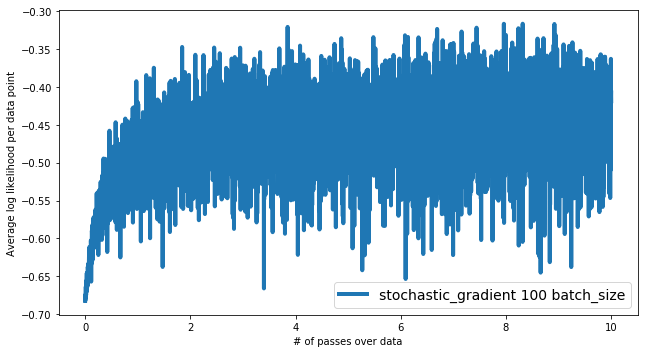

In [60]:
make_plot(batch_size=batch_size,label="stochastic_gradient 100 batch_size",len_data=len(train_matrix),log_likelihood_all=lla_batch100)

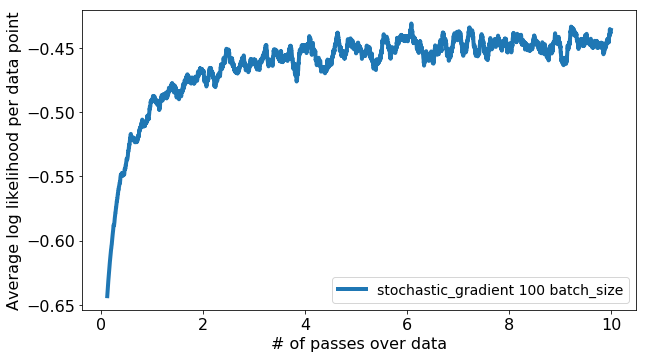

In [61]:
make_plot(batch_size=batch_size,label="stochastic_gradient 100 batch_size",len_data=len(train_matrix),log_likelihood_all=lla_batch100,smoothing_window=60)

In [63]:
step_size=1e-1
batch_size=100
max_iter = 200

In [64]:
w8s_iter200 , lla_iter200 = Logistic_Regression_SG(train_matrix,train_label,init_weights,step_size,batch_size,max_iter)

Iteration   0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration   1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration   2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration   3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration   4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration   5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration   6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration   7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration   8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration   9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration  10: Average log likelihood (of data points in batch [01000:01100]) = 

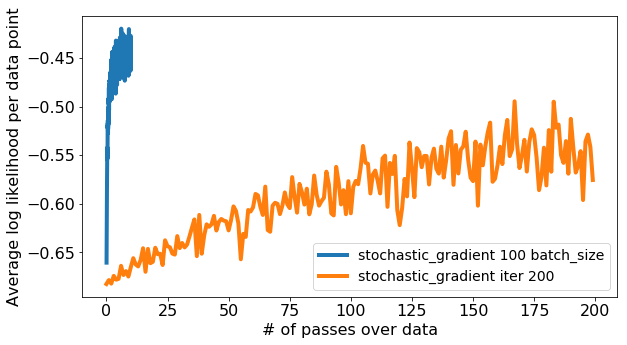

In [67]:
make_plot(batch_size=batch_size,label="stochastic_gradient 100 batch_size",len_data=len(train_matrix),log_likelihood_all=lla_batch100,smoothing_window=30)
make_plot(batch_size=len(train_matrix),label="stochastic_gradient iter 200",len_data=len(train_matrix),log_likelihood_all=lla_iter200)